# ERA V2 S5 ASSIGNMENT

#### CODE BLOCK: 1
Imports necessary modules from the PyTorch and torchvision libraries.

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

#from utils import *
%run utils.py         #to run every update in utils.py till code complition

#from model import Net
%run model.py


!pip install torchsummary #Installs torch summary, if not available
from torchsummary import summary

<Figure size 640x480 with 0 Axes>

#### CODE BLOCK: 2
set device as "cuda" if available or as "cpu"


In [30]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

#### CODE BLOCK: 3
Train and Test data transformations


In [31]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

#### CODE BLOCK: 4
Download the dataset to train_data and test_data

In [32]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

#### CODE BLOCK: 5

Defining Batch size, kwargs, test_loader, train_loader

In [33]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

#### CODE BLOCK: 6
Plot data and label using plt function from matpltlib

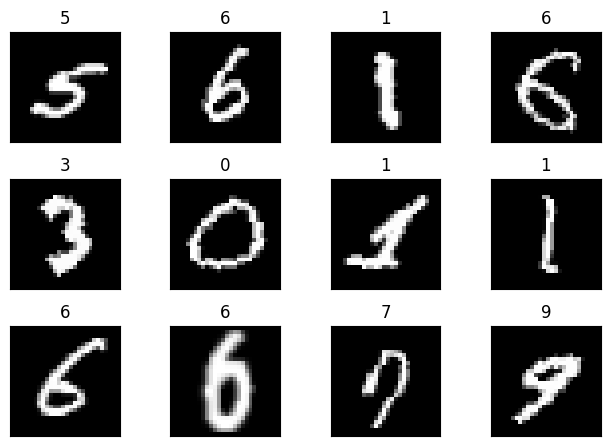

In [35]:
batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

#### CODE BLOCK: 7
Instantiating the model and moving it to the specified device

In [36]:
model = Net().to(device)

# Generating a summary of the model architecture
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


#### CODE BLOCK: 8
 Data to plot accuracy and loss graphs

In [27]:

train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}



#### CODE BLOCK: 9
Function to train and test data

In [38]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Predict
        pred = model(data)

        # Calculate loss
        loss = criterion(pred, target)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        correct += GetCorrectPredCount(pred, target)
        processed += len(data)

        pbar.set_description(
            desc=f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))


def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            # sum up batch loss
            test_loss += criterion(output, target, reduction='sum').item()

            correct += GetCorrectPredCount(output, target)

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


#### CODE BLOCK: 10

In [39]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=1.4888 Batch_id=117 Accuracy=30.63: 100%|██████████| 118/118 [00:22<00:00,  5.17it/s]


Test set: Average loss: 1.4841, Accuracy: 6447/10000 (64.47%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.1058 Batch_id=117 Accuracy=87.91: 100%|██████████| 118/118 [00:22<00:00,  5.23it/s]


Test set: Average loss: 0.1138, Accuracy: 9668/10000 (96.68%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.1701 Batch_id=117 Accuracy=95.74: 100%|██████████| 118/118 [00:23<00:00,  4.97it/s]


Test set: Average loss: 0.0707, Accuracy: 9783/10000 (97.83%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0689 Batch_id=117 Accuracy=96.87: 100%|██████████| 118/118 [00:22<00:00,  5.23it/s]


Test set: Average loss: 0.0513, Accuracy: 9848/10000 (98.48%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0278 Batch_id=117 Accuracy=97.36: 100%|██████████| 118/118 [00:22<00:00,  5.24it/s]


Test set: Average loss: 0.0469, Accuracy: 9848/10000 (98.48%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.1906 Batch_id=117 Accuracy=97.73: 100%|██████████| 118/118 [00:23<00:00,  5.01it/s]


Test set: Average loss: 0.0416, Accuracy: 9873/10000 (98.73%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0320 Batch_id=117 Accuracy=97.94: 100%|██████████| 118/118 [00:21<00:00,  5.47it/s]


Test set: Average loss: 0.0374, Accuracy: 9877/10000 (98.77%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0160 Batch_id=117 Accuracy=98.13: 100%|██████████| 118/118 [00:21<00:00,  5.50it/s]


Test set: Average loss: 0.0365, Accuracy: 9882/10000 (98.82%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0308 Batch_id=117 Accuracy=98.36: 100%|██████████| 118/118 [00:22<00:00,  5.33it/s]


Test set: Average loss: 0.0355, Accuracy: 9894/10000 (98.94%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0162 Batch_id=117 Accuracy=98.46: 100%|██████████| 118/118 [00:22<00:00,  5.26it/s]


Test set: Average loss: 0.0288, Accuracy: 9910/10000 (99.10%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0650 Batch_id=117 Accuracy=98.60: 100%|██████████| 118/118 [00:22<00:00,  5.20it/s]


Test set: Average loss: 0.0328, Accuracy: 9887/10000 (98.87%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0516 Batch_id=117 Accuracy=98.58: 100%|██████████| 118/118 [00:22<00:00,  5.27it/s]


Test set: Average loss: 0.0325, Accuracy: 9896/10000 (98.96%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0807 Batch_id=117 Accuracy=98.72: 100%|██████████| 118/118 [00:22<00:00,  5.28it/s]


Test set: Average loss: 0.0283, Accuracy: 9913/10000 (99.13%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0218 Batch_id=117 Accuracy=98.78: 100%|██████████| 118/118 [00:22<00:00,  5.24it/s]


Test set: Average loss: 0.0252, Accuracy: 9917/10000 (99.17%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0187 Batch_id=117 Accuracy=98.82: 100%|██████████| 118/118 [00:22<00:00,  5.17it/s]


Test set: Average loss: 0.0283, Accuracy: 9909/10000 (99.09%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0058 Batch_id=117 Accuracy=99.00: 100%|██████████| 118/118 [00:22<00:00,  5.33it/s]


Test set: Average loss: 0.0228, Accuracy: 9928/10000 (99.28%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0122 Batch_id=117 Accuracy=99.12: 100%|██████████| 118/118 [00:21<00:00,  5.51it/s]


Test set: Average loss: 0.0231, Accuracy: 9925/10000 (99.25%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0248 Batch_id=117 Accuracy=99.14: 100%|██████████| 118/118 [00:21<00:00,  5.48it/s]


Test set: Average loss: 0.0224, Accuracy: 9929/10000 (99.29%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0079 Batch_id=117 Accuracy=99.14: 100%|██████████| 118/118 [00:22<00:00,  5.29it/s]


Test set: Average loss: 0.0233, Accuracy: 9929/10000 (99.29%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0141 Batch_id=117 Accuracy=99.19: 100%|██████████| 118/118 [00:22<00:00,  5.28it/s]


Test set: Average loss: 0.0232, Accuracy: 9928/10000 (99.28%)

Adjusting learning rate of group 0 to 1.0000e-03.


#### CODE BLOCK: 11

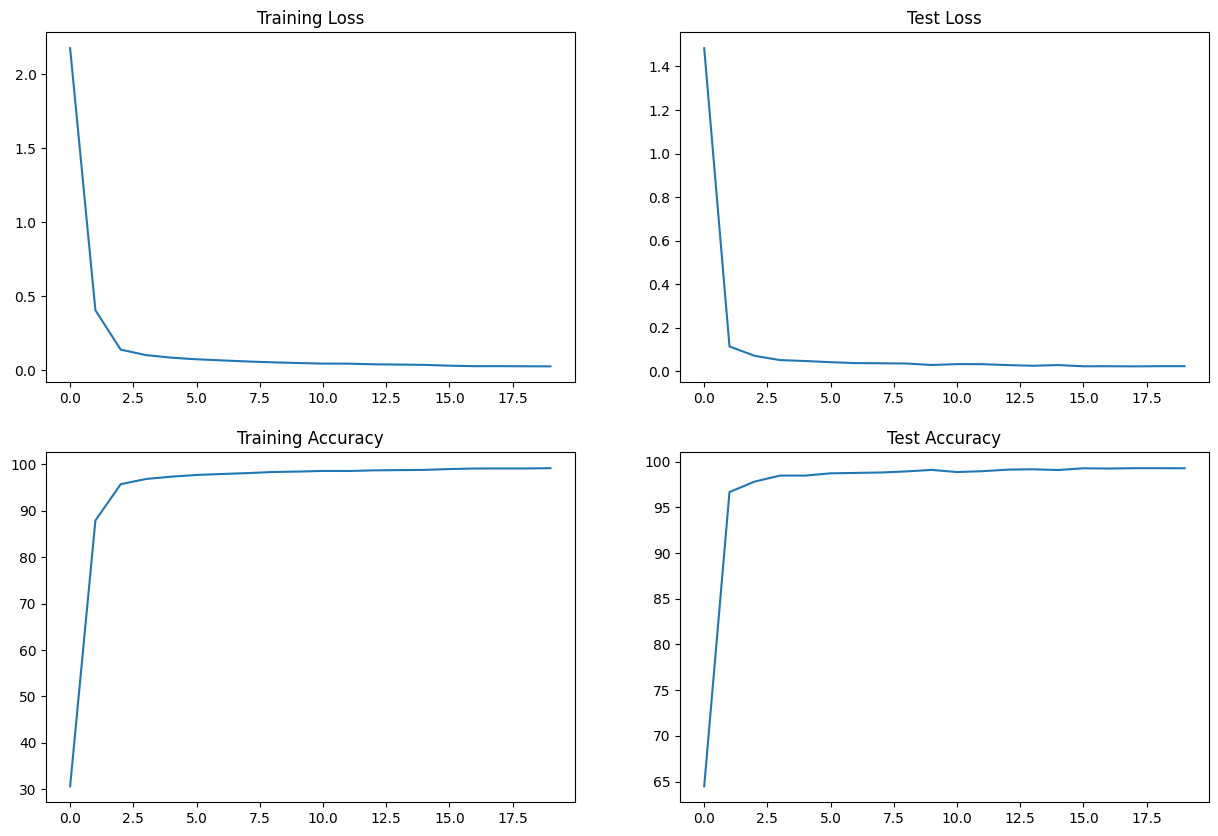

In [41]:
viewAnalysisPlt(train_losses,train_acc,test_losses,test_acc)

#### CODE BLOCK: 12

In [42]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------
